In [433]:
import pandas as pd
import numpy as np
import sys
import requests
import pprint

import datetime
import pytz
import importlib
import matplotlib.pyplot as plt


import datetime, json, math
from google.cloud import bigquery
from numpy_ext import rolling_apply as rolling_apply_ext

In [2]:
import os

if os.path.exists('credential.json'):
    os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = os.path.join(os.getcwd(), 'credential.json')

In [3]:
df = pd.concat([pd.read_pickle('algo/data/binance/df_binance_20230809.pkl'), pd.read_pickle('algo/data/binance/df_binance_20230810.pkl')])

In [4]:
df_close = df.pivot(index='timestamp', columns='symbol', values='close')

In [5]:
dfi = df.set_index(['timestamp', 'symbol'])

In [572]:
dfst = df.set_index(['symbol', 'timestamp'])

In [6]:
dfi

,,open,high,low,close,volume
timestamp,symbol,,,,,
2023-08-09 00:00:00+00:00,1INCHBUSD,0.3066,0.3066,0.3066,0.3066,0.0
2023-08-09 00:01:00+00:00,1INCHBUSD,0.3066,0.3066,0.3066,0.3066,0.0
2023-08-09 00:02:00+00:00,1INCHBUSD,0.3066,0.3066,0.3066,0.3066,0.0
2023-08-09 00:03:00+00:00,1INCHBUSD,0.3066,0.3066,0.3066,0.3066,0.0
2023-08-09 00:04:00+00:00,1INCHBUSD,0.3066,0.3066,0.3066,0.3066,0.0
...,...,...,...,...,...,...
2023-08-10 23:55:00+00:00,ZRXUSDT,0.2124,0.2124,0.2124,0.2124,1866.0
2023-08-10 23:56:00+00:00,ZRXUSDT,0.2124,0.2124,0.2124,0.2124,0.0
2023-08-10 23:57:00+00:00,ZRXUSDT,0.2124,0.2124,0.2124,0.2124,0.0


In [274]:
dfst

open    high     low   close  volume
symbol    timestamp                                                        
1INCHBUSD 2023-08-09 00:00:00+00:00  0.3066  0.3066  0.3066  0.3066     0.0
          2023-08-09 00:01:00+00:00  0.3066  0.3066  0.3066  0.3066     0.0
          2023-08-09 00:02:00+00:00  0.3066  0.3066  0.3066  0.3066     0.0
          2023-08-09 00:03:00+00:00  0.3066  0.3066  0.3066  0.3066     0.0
          2023-08-09 00:04:00+00:00  0.3066  0.3066  0.3066  0.3066     0.0
...                                     ...     ...     ...     ...     ...
ZRXUSDT   2023-08-10 23:55:00+00:00  0.2124  0.2124  0.2124  0.2124  1866.0
          2023-08-10 23:56:00+00:00  0.2124  0.2124  0.2124  0.2124     0.0
          2023-08-10 23:57:00+00:00  0.2124  0.2124  0.2124  0.2124     0.0
          2023-08-10 23:58:00+00:00  0.2124  0.2124  0.2124  0.2124     0.0
          2023-08-10 23:59:00+00:00  0.2124  0.2124  0.2124  0.2124     0.0

[1866240 rows x 5 columns]

In [341]:
dfst.index.get_level_values(0)[0]

'1INCHBUSD'

In [472]:
dfs = dfi.xs('DREPUSDT', level=1)

<Axes: xlabel='timestamp'>

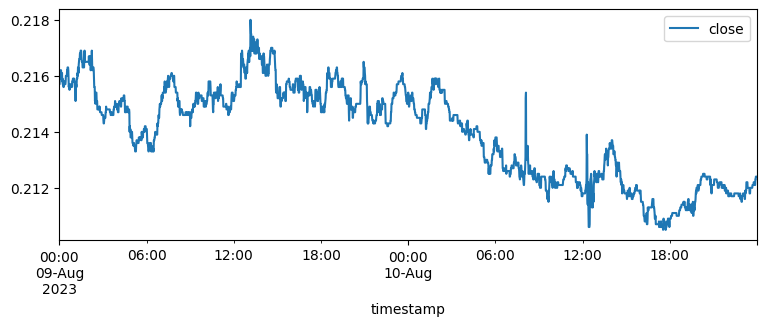

In [576]:
dfs[['close']].plot(figsize=(9,3))

In [14]:
all_symbols = df.symbol.unique()

In [15]:
all_symbols

array(['1INCHBUSD', '1INCHUSDT', 'AAVEBUSD', 'AAVEUSDT', 'ACABUSD',
       'ACAUSDT', 'ACHBUSD', 'ACHUSDT', 'ACMUSDT', 'ADABUSD',
       'ADADOWNUSDT', 'ADAUPUSDT', 'ADAUSDT', 'ADXBUSD', 'ADXUSDT',
       'AERGOBUSD', 'AERGOUSDT', 'AGIXBUSD', 'AGIXUSDT', 'AGLDBUSD',
       'AGLDUSDT', 'AKROBUSD', 'AKROUSDT', 'ALCXBUSD', 'ALCXUSDT',
       'ALGOBUSD', 'ALGOUSDT', 'ALICEBUSD', 'ALICEUSDT', 'ALPACAUSDT',
       'ALPHABUSD', 'ALPHAUSDT', 'ALPINEBUSD', 'ALPINEUSDT', 'AMBBUSD',
       'AMBUSDT', 'AMPBUSD', 'AMPUSDT', 'ANKRBUSD', 'ANKRUSDT', 'ANTBUSD',
       'ANTUSDT', 'APEBUSD', 'APEUSDT', 'API3USDT', 'APTBUSD', 'APTUSDT',
       'ARBUSD', 'ARBUSDT', 'ARDRUSDT', 'ARKBUSD', 'ARKMUSDT', 'ARPABUSD',
       'ARPAUSDT', 'ARUSDT', 'ASRBUSD', 'ASRUSDT', 'ASTRBUSD', 'ASTRUSDT',
       'ASTUSDT', 'ATAUSDT', 'ATMBUSD', 'ATMUSDT', 'ATOMBUSD', 'ATOMUSDT',
       'AUCTIONBUSD', 'AUCTIONUSDT', 'AUDIOBUSD', 'AUDIOUSDT', 'AVABUSD',
       'AVAUSDT', 'AVAXBUSD', 'AVAXUSDT', 'AXSBUSD', 'AXSUSDT',
       'BAD

In [577]:
def get_changes(values):
    '''
    values is a 2 dimensional array.
    '''
    l, m = values.shape
    if l < 1: return {}

    ch_largest, ch_smallest = np.zeros(m), np.zeros(m)
    distance_largest_ch, distance_smallest_ch = np.ones(m), np.ones(m)
    ch_since_largest, ch_since_smallest = np.zeros(m), np.zeros(m)

    head_i, tail_i = 1, l-2
    fisrt_v, last_v = values[0], values[-1]
    
    for i, v in enumerate(values):
        if i < head_i or i > tail_i: continue
        ch = (v - fisrt_v) / fisrt_v
        ch_since = (last_v - v) / v
        d =  l-1-i
        distance_largest_ch = np.where(np.greater(ch_largest, ch), distance_largest_ch, d)
        distance_smallest_ch = np.where(np.less(ch_smallest, ch), distance_smallest_ch, d)
        ch_since_largest = np.where(np.greater(ch_largest, ch), ch_since_largest, ch_since)
        ch_since_smallest = np.where(np.less(ch_smallest, ch), ch_since_smallest, ch_since)
        ch_largest = np.where(np.greater(ch_largest, ch), ch_largest, ch)
        ch_smallest = np.where(np.less(ch_smallest, ch), ch_smallest, ch)

    #"""
    return {
        'ch_largest': ch_largest, 'ch_smallest': ch_smallest,
        'ch_since_largest': ch_since_largest, 'ch_since_smallest': ch_since_smallest,
        'distance_largest_ch': distance_largest_ch, 'distance_smallest_ch': distance_smallest_ch,
        }
    #"""
    #return ch_largest, ch_smallest


In [28]:
changes = get_changes(df_close[list(df_close.columns)].values)

In [29]:
len(changes['ch_largest'])

648

In [30]:
dfi.loc[dfi.index.get_level_values(0)[-1],'ch_largest'] = changes['ch_largest']

In [31]:
dfi.loc[dfi.index.get_level_values(0)[-1],:]

,open,high,low,close,volume,ch_largest
symbol,,,,,,
1INCHBUSD,0.30700,0.30700,0.30700,0.30700,0.000,0.008154
1INCHUSDT,0.30740,0.30740,0.30740,0.30740,162.600,0.005854
AAVEBUSD,67.02000,67.02000,67.02000,67.02000,0.000,0.048044
AAVEUSDT,67.11000,67.12000,67.09000,67.09000,10.029,0.046634
ACABUSD,0.05720,0.05720,0.05720,0.05720,0.000,0.027730
...,...,...,...,...,...,...
ZENUSDT,8.62000,8.62000,8.62000,8.62000,0.000,0.011468
ZILBUSD,0.02001,0.02001,0.02001,0.02001,0.000,0.004965
ZILUSDT,0.02004,0.02004,0.02004,0.02004,0.000,0.005456


In [32]:
dfi.xs(dfi.index.get_level_values(1)[-1], level=1)

,open,high,low,close,volume,ch_largest
timestamp,,,,,,
2023-08-09 00:00:00+00:00,0.2159,0.2159,0.2157,0.2157,2201.0,NaN
2023-08-09 00:01:00+00:00,0.2157,0.2157,0.2157,0.2157,0.0,NaN
2023-08-09 00:02:00+00:00,0.2160,0.2160,0.2160,0.2160,74.0,NaN
2023-08-09 00:03:00+00:00,0.2161,0.2162,0.2161,0.2162,1313.0,NaN
2023-08-09 00:04:00+00:00,0.2162,0.2162,0.2162,0.2162,0.0,NaN
...,...,...,...,...,...,...
2023-08-10 23:55:00+00:00,0.2124,0.2124,0.2124,0.2124,1866.0,NaN
2023-08-10 23:56:00+00:00,0.2124,0.2124,0.2124,0.2124,0.0,NaN
2023-08-10 23:57:00+00:00,0.2124,0.2124,0.2124,0.2124,0.0,NaN


In [375]:
def get_changes_1dim(values):
    '''
    values is a 1 dimensional array.
    '''
    l = values.shape[0]
    if l < 1: return None

    if len(values.shape) == 2:
        values = [v[0] for v in values]

    ch_largest, ch_smallest = 0, 0
    distance_largest_ch, distance_smallest_ch = 1, 1
    ch_since_largest, ch_since_smallest = 0, 0

    fisrt_v, last_v = values[0], values[-1]

    for i, v in enumerate(values):
        ch = (v - fisrt_v) / fisrt_v
        ch_since = (last_v - v) / v
        d =  l-1-i
        distance_largest_ch, ch_since_largest, ch_largest = (distance_largest_ch, ch_since_largest, ch_largest,) if ch_largest > ch else (d, ch_since, ch,)
        distance_smallest_ch, ch_since_smallest, ch_smallest = (distance_smallest_ch, ch_since_smallest, ch_smallest,) if ch_smallest < ch else (d, ch_since, ch,)


    #"""
    return {
        'value': values[-1],
        'ch_largest': ch_largest, 'ch_smallest': ch_smallest,
        'ch_since_largest': ch_since_largest, 'ch_since_smallest': ch_since_smallest,
        'distance_largest_ch': distance_largest_ch, 'distance_smallest_ch': distance_smallest_ch,
        }
    #"""
    #return ch_largest, ch_smallest

In [608]:
from collections import defaultdict

def get_feature_df_(dfs, window):
    '''
    dfs is df for single symbol.
    '''
    dfs = dfs[['close']]
    list_of_dict = [get_changes_1dim(df_.values) for df_ in dfs.rolling(window, min_periods=window)]
    dict_of_list = defaultdict(list)
    for d in list_of_dict:
        for k, v in d.items():
           dict_of_list[k].append(v)
    #print(list_of_dict)
    return pd.DataFrame.from_dict(dict_of_list).set_index(dfs.index)


def get_feature_df(dfs, window):
    return pd.DataFrame([get_changes_1dim(df_.values) for df_ in dfs[['close']].rolling(30, min_periods=30)], index=dfs.index)

In [606]:
defaultjump_window = 30
default_jump_threshold, default_drop_from_jump_threshold, default_exit_jumpt_threshold = 0.20, -0.05, 0.03

class JitterRecoveryTradingParam:
    def __init__(self, jump_window, jump_threshold, drop_from_jump_threshold, exit_jumpt_threshold):
        self.jump_window = jump_window
        self.jump_thresholdv= jump_threshold
        self.drop_from_jump_threshold = drop_from_jump_threshold
        self.exit_jumpt_threshold = exit_jumpt_threshold

    def get_default_param():
        return JitterRecoveryTradingParam(
            default_jump_threshold, default_jump_threshold, default_drop_from_jump_threshold, default_exit_jumpt_threshold)

In [607]:
def add_trading_columns(df_feature, jitter_recover_trading_param):
    in_positions = [0]
    lowest_since_enters = [0]
    timedelta_since_position_enters = [0]
    value_at_enters = [0]
    ch_from_enters = [0]
    ch_from_lowest_since_enters = [0]
    for i in range(1, len(df_feature.index)):
        in_position = in_positions[-1]
        value_at_enter = value_at_enters[-1]
        lowest_since_enter = lowest_since_enters[-1]
        timedelta_since_position_enter = timedelta_since_position_enters[-1]
        ch_from_enter = ch_from_enters[-1]
        ch_from_lowest_since_enter = ch_from_lowest_since_enters[-1]
        # if i_decision = i-1, the position of current is one step delayed to make it more realistic.
        # on the other hand, it might be too unrealistically strigent condition
        decision_delay = 0
        i_decision = i - decision_delay
        v = df_feature.value.values[i]
        if in_position == 1:
            if v < lowest_since_enter:
                lowest_since_enter = v
            timedelta_since_position_enter = timedelta_since_position_enters[-1] + 1
            ch_from_enter =  (v - value_at_enter) / value_at_enter
            ch_from_lowest_since_enter = (v - lowest_since_enter) / lowest_since_enter
    
            if ch_from_lowest_since_enter > jitter_recover_trading_param.exit_jumpt_threshold:
                in_position = 0
        elif df_feature.ch_largest.values[i_decision] > jitter_recover_trading_param.jump_thresholdv \
            and df_feature.ch_since_largest.values[i_decision] < jitter_recover_trading_param.drop_from_jump_threshold: 
            in_position = 1
            value_at_enter = v
            lowest_since_enter = df_feature.value.values[i]
            timedelta_since_position_enter = 0
            ch_from_enter = 0
            ch_from_lowest_since_enter = 0
        else:
            in_position = 0
            value_at_enter = 0
            lowest_since_enter = 0
            timedelta_since_position_enter = 0
            ch_from_enter = 0
            ch_from_lowest_since_enter = 0
    
        in_positions.append(in_position)
        value_at_enters.append(value_at_enter)
        lowest_since_enters.append(lowest_since_enter)
        timedelta_since_position_enters.append(timedelta_since_position_enter)
        ch_from_enters.append(ch_from_enter)
        ch_from_lowest_since_enters.append(ch_from_lowest_since_enter)
    
    df_feature['in_position'] = in_positions
    df_feature['value_at_enter'] = value_at_enters
    df_feature['position_changed'] = df_feature.in_position.diff()
    df_feature['lowest_since_enter'] = lowest_since_enters
    df_feature['timedelta_since_position_enter'] = timedelta_since_position_enters
    df_feature['ch_from_enter'] = ch_from_enters
    df_feature['ch_from_lowest_since_enter'] = ch_from_lowest_since_enters
    df_feature['profit_raw'] = -df_feature.value.diff() * df_feature.in_position.shift()
    df_feature['profit'] = -df_feature.value.pct_change() * df_feature.in_position.shift()

    return df_feature

In [578]:
dfs = dfi.xs('AKROBUSD', level=1)

In [579]:
df_feature = get_feature_df(dfs, 30)

In [580]:
df_trading = add_trading_columns(df_feature)

In [601]:
df_feature.head(3)

,value,ch_largest,ch_smallest,ch_since_largest,ch_since_smallest,distance_largest_ch,distance_smallest_ch,in_position,value_at_enter,position_changed,lowest_since_enter,timedelta_since_position_enter,ch_from_enter,ch_from_lowest_since_enter,profit_raw,profit
timestamp,,,,,,,,,,,,,,,,
2023-08-09 00:00:00+00:00,0.0677,0.0,0.000000,0.000000,0.0,0,0,0,0.0,NaN,0.0,0,0.0,0.0,NaN,NaN
2023-08-09 00:01:00+00:00,0.0669,0.0,-0.011817,-0.011817,0.0,1,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
2023-08-09 00:02:00+00:00,0.0661,0.0,-0.023634,-0.023634,0.0,2,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0


In [602]:
df_trading.head(3)

,value,ch_largest,ch_smallest,ch_since_largest,ch_since_smallest,distance_largest_ch,distance_smallest_ch,in_position,value_at_enter,position_changed,lowest_since_enter,timedelta_since_position_enter,ch_from_enter,ch_from_lowest_since_enter,profit_raw,profit
timestamp,,,,,,,,,,,,,,,,
2023-08-09 00:00:00+00:00,0.0677,0.0,0.000000,0.000000,0.0,0,0,0,0.0,NaN,0.0,0,0.0,0.0,NaN,NaN
2023-08-09 00:01:00+00:00,0.0669,0.0,-0.011817,-0.011817,0.0,1,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
2023-08-09 00:02:00+00:00,0.0661,0.0,-0.023634,-0.023634,0.0,2,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0


<Axes: xlabel='timestamp'>

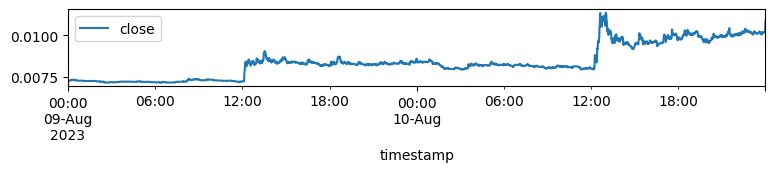

In [583]:
dfs[['close']].plot(figsize=(9,1))

<Axes: xlabel='timestamp'>

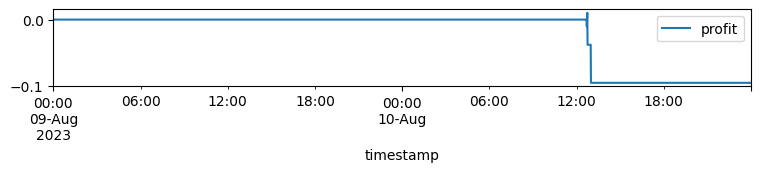

In [584]:
df_trading[['profit']].cumsum().plot(figsize=(9,1))

<Axes: xlabel='timestamp'>

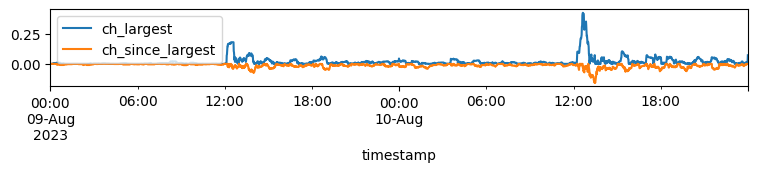

In [585]:
df_trading[['ch_largest', 'ch_since_largest']].plot(figsize=(9,1))

<Axes: xlabel='timestamp'>

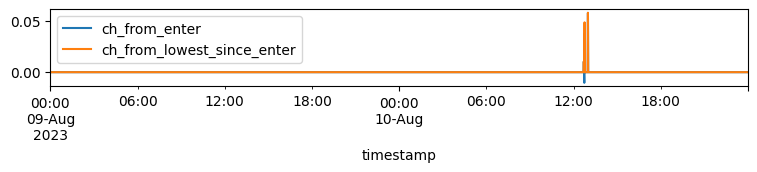

In [586]:
df_trading[['ch_from_enter', 'ch_from_lowest_since_enter']].plot(figsize=(9,1))

<Axes: xlabel='timestamp'>

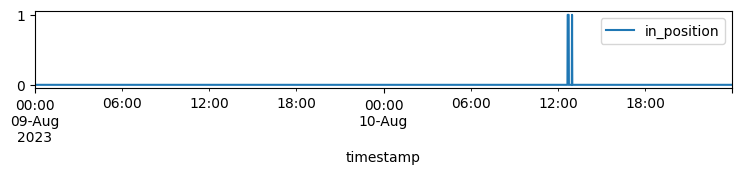

In [587]:
df_trading[['in_position']].plot(figsize=(9,1))

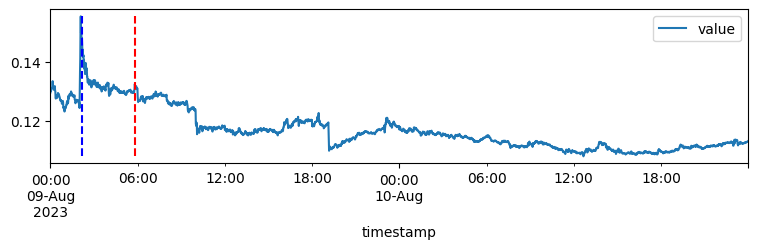

In [531]:
ax = df_trading[['value']].plot(figsize=(9,2))
ymin, ymax = df_trading[['value']].min(), df_trading[['value']].max()

ax.vlines(x=list(df_trading[df_trading.position_changed == +1].index), ymin=ymin, ymax=ymax, color='b', linestyles='dashed', label='enter')
ax.vlines(x=list(df_trading[df_trading.position_changed == -1].index), ymin=ymin, ymax=ymax, color='r', linestyles='dashed', label='enter')

plt.show()

In [594]:
symbol_with_jumps = [s for s in list(set(list(dfst[dfst.ch_largest > 0.15].index.get_level_values(0)))) if 'USDT' in s]
symbol_with_jumps

['AKROUSDT',
 'CLVUSDT',
 'BNTUSDT',
 'DREPUSDT',
 'DODOUSDT',
 'APTUSDT',
 'OXTUSDT']

In [569]:
df_trading.columns

Index(['value', 'ch_largest', 'ch_smallest', 'ch_since_largest',
       'ch_since_smallest', 'distance_largest_ch', 'distance_smallest_ch',
       'in_position', 'value_at_enter', 'position_changed',
       'lowest_since_enter', 'timedelta_since_position_enter', 'ch_from_enter',
       'ch_from_lowest_since_enter', 'profit_raw', 'profit'],
      dtype='object')

In [574]:

dfs = dfi.xs(all_symbols[0], level=1)
df_feature = get_feature_df(dfs, 30)
df_trading = add_trading_columns(df_feature)
for column in df_trading.columns:
    dfst.loc[symbol, column] = df_trading[column].values

In [609]:
jitter_recover_trading_param = JitterRecoveryTradingParam.get_default_param()
for symbol in symbol_with_jumps:
    if 'USDT' not in symbol: continue
    dfs = dfi.xs(symbol, level=1)
    df_feature = get_feature_df(dfs, jitter_recover_trading_param.jump_window)
    df_trading = add_trading_columns(df_feature, jitter_recover_trading_param)
    for column in df_trading.columns:
        dfst.loc[symbol, column] = df_trading[column].values

In [610]:
len(all_symbols)

648

In [611]:
dfst.columns

Index(['open', 'high', 'low', 'close', 'volume', 'value', 'ch_largest',
       'ch_smallest', 'ch_since_largest', 'ch_since_smallest',
       'distance_largest_ch', 'distance_smallest_ch', 'in_position',
       'value_at_enter', 'position_changed', 'lowest_since_enter',
       'timedelta_since_position_enter', 'ch_from_enter',
       'ch_from_lowest_since_enter', 'profit_raw', 'profit'],
      dtype='object')

<Axes: xlabel='timestamp'>

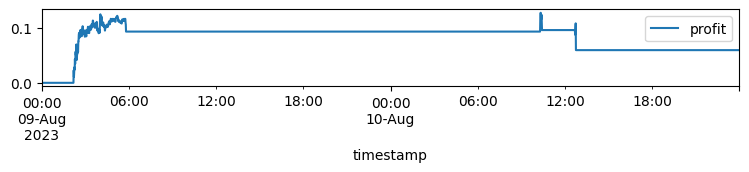

In [612]:
dfst[['profit']].groupby('timestamp').sum().cumsum().plot(figsize=(9,1))

In [613]:
dfst[['profit']].groupby('symbol').sum().sort_values('profit')

,profit
symbol,
AKROUSDT,-0.036290
1INCHBUSD,0.000000
OSMOUSDT,0.000000
PAXGBUSD,0.000000
PAXGUSDT,0.000000
...,...
FDUSDUSDT,0.000000
FETBUSD,0.000000
FIDABUSD,0.000000


In [338]:
list(set(list(dfst[dfst.ch_largest > 0.15].index.get_level_values(0))))

['AKROUSDT',
 'AKROBUSD',
 'CLVBUSD',
 'OXTUSDT',
 'CLVUSDT',
 'BNTUSDT',
 'DREPUSDT',
 'APTUSDT',
 'APTBUSD',
 'DODOUSDT',
 'DREPBUSD',
 'SNMBUSD',
 'DODOBUSD']

In [340]:
dfst[(dfst.ch_largest > 0.15) & (dfst.ch_since_largest < 0)]

open     high      low    close  \
symbol   timestamp                                                       
AKROBUSD 2023-08-09 12:14:00+00:00  0.00841  0.00847  0.00826  0.00837   
         2023-08-09 12:15:00+00:00  0.00838  0.00840  0.00807  0.00817   
         2023-08-09 12:16:00+00:00  0.00815  0.00825  0.00801  0.00822   
         2023-08-09 12:17:00+00:00  0.00822  0.00825  0.00812  0.00822   
         2023-08-09 12:18:00+00:00  0.00822  0.00822  0.00808  0.00815   
...                                     ...      ...      ...      ...   
OXTUSDT  2023-08-10 10:14:00+00:00  0.08810  0.08880  0.08790  0.08830   
         2023-08-10 10:15:00+00:00  0.08830  0.08900  0.08820  0.08890   
         2023-08-10 10:16:00+00:00  0.08890  0.08990  0.08880  0.08920   
         2023-08-10 10:17:00+00:00  0.08920  0.08940  0.08850  0.08900   
         2023-08-10 10:18:00+00:00  0.08900  0.08920  0.08660  0.08680   

                                       volume  ch_largest  ch_smallest  \
symbol   timestamp                                                       
AKROBUSD 2023-08-09 12:14:00+00:00  2365736.0    0.166667    -0.002778   
         2023-08-09 12:15:00+00:00  5403170.0    0.169916     0.000000   
         2023-08-09 12:16:00+00:00  2602787.0    0.169916     0.000000   
         2023-08-09 12:17:00+00:00  1718583.0    0.169916     0.000000   
         2023-08-09 12:18:00+00:00   470238.0    0.168289     0.000000   
...                                       ...         ...          ...   
OXTUSDT  2023-08-10 10:14:00+00:00  1216137.0    0.193631    -0.011465   
         2023-08-10 10:15:00+00:00   637241.0    0.199744    -0.006402   
         2023-08-10 10:16:00+00:00  1286884.0    0.201282    -0.005128   
         2023-08-10 10:17:00+00:00   440919.0    0.207474     0.000000   
         2023-08-10 10:18:00+00:00  1581124.0    0.207474     0.000000   

                                    ch_since_largest  ch_since_smallest  \
symbol   timestamp                                                        
AKROBUSD 2023-08-09 12:14:00+00:00         -0.003571           0.165738   
         2023-08-09 12:15:00+00:00         -0.027381           0.137883   
         2023-08-09 12:16:00+00:00         -0.021429           0.144847   
         2023-08-09 12:17:00+00:00         -0.021429           0.144847   
         2023-08-09 12:18:00+00:00         -0.029762           0.133519   
...                                              ...                ...   
OXTUSDT  2023-08-10 10:14:00+00:00         -0.057631           0.137887   
         2023-08-10 10:15:00+00:00         -0.051227           0.145619   
         2023-08-10 10:16:00+00:00         -0.048026           0.149485   
         2023-08-10 10:17:00+00:00         -0.050160           0.146907   
         2023-08-10 10:18:00+00:00         -0.073639           0.118557   

                                    distance_largest_ch  distance_smallest_ch  
symbol   timestamp                                                             
AKROBUSD 2023-08-09 12:14:00+00:00                  1.0                  26.0  
         2023-08-09 12:15:00+00:00                  2.0                  27.0  
         2023-08-09 12:16:00+00:00                  3.0                  28.0  
         2023-08-09 12:17:00+00:00                  4.0                  29.0  
         2023-08-09 12:18:00+00:00                  5.0                  24.0  
...                                                 ...                   ...  
OXTUSDT  2023-08-10 10:14:00+00:00                 12.0                  25.0  
         2023-08-10 10:15:00+00:00                 13.0                  26.0  
         2023-08-10 10:16:00+00:00                 14.0                  27.0  
         2023-08-10 10:17:00+00:00                 15.0                  28.0  
         2023-08-10 10:18:00+00:00                 16.0                  29.0  

[254 rows x 11 columns]

In [339]:
dfst[(dfst.ch_largest > 0.15) & (dfst.ch_since_largest < 0)].loc['AKROBUSD']

,open,high,low,close,volume,ch_largest,ch_smallest,ch_since_largest,ch_since_smallest,distance_largest_ch,distance_smallest_ch
timestamp,,,,,,,,,,,
2023-08-09 12:14:00+00:00,0.00841,0.00847,0.00826,0.00837,2365736.0,0.166667,-0.002778,-0.003571,0.165738,1.0,26.0
2023-08-09 12:15:00+00:00,0.00838,0.00840,0.00807,0.00817,5403170.0,0.169916,0.000000,-0.027381,0.137883,2.0,27.0
2023-08-09 12:16:00+00:00,0.00815,0.00825,0.00801,0.00822,2602787.0,0.169916,0.000000,-0.021429,0.144847,3.0,28.0
2023-08-09 12:17:00+00:00,0.00822,0.00825,0.00812,0.00822,1718583.0,0.169916,0.000000,-0.021429,0.144847,4.0,29.0
2023-08-09 12:18:00+00:00,0.00822,0.00822,0.00808,0.00815,470238.0,0.168289,0.000000,-0.029762,0.133519,5.0,24.0
2023-08-09 12:19:00+00:00,0.00817,0.00850,0.00816,0.00829,5936551.0,0.168289,0.000000,-0.013095,0.152990,6.0,25.0
2023-08-09 12:20:00+00:00,0.00825,0.00831,0.00824,0.00831,427091.0,0.168289,0.000000,-0.010714,0.155772,7.0,26.0
2023-08-09 12:22:00+00:00,0.00844,0.00850,0.00826,0.00840,2173266.0,0.176634,0.000000,-0.007092,0.168289,1.0,28.0
2023-08-09 12:23:00+00:00,0.00840,0.00847,0.00836,0.00838,877427.0,0.176634,0.000000,-0.009456,0.165508,2.0,29.0


In [293]:
dfst.index.get_level_values(0)[0]

'1INCHBUSD'

In [304]:
for column in df_feature.columns:
    dfst.loc[dfst.index.get_level_values(0)[0], column] = df_feature[column].values

In [305]:
dfst.loc[dfst.index.get_level_values(0)[0]]

,open,high,low,close,volume,ch_largest,ch_smallest,ch_since_largest,ch_since_smallest,distance_largest_ch,distance_smallest_ch
timestamp,,,,,,,,,,,
2023-08-09 00:00:00+00:00,0.3066,0.3066,0.3066,0.3066,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
2023-08-09 00:01:00+00:00,0.3066,0.3066,0.3066,0.3066,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
2023-08-09 00:02:00+00:00,0.3066,0.3066,0.3066,0.3066,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
2023-08-09 00:03:00+00:00,0.3066,0.3066,0.3066,0.3066,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
2023-08-09 00:04:00+00:00,0.3066,0.3066,0.3066,0.3066,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2023-08-10 23:55:00+00:00,0.3070,0.3070,0.3070,0.3070,0.0,0.000326,0.0,0.0,0.000326,0.0,11.0
2023-08-10 23:56:00+00:00,0.3070,0.3070,0.3070,0.3070,0.0,0.000326,0.0,0.0,0.000326,0.0,12.0
2023-08-10 23:57:00+00:00,0.3070,0.3070,0.3070,0.3070,0.0,0.000326,0.0,0.0,0.000326,0.0,13.0
